## UC-Project

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

import multiprocessing as mp
import osmnx as ox
import networkx as nx

### Paris Network Building

Implementation of the network.py on Paris. Coord_transform doesn't need to be used since Paris does not use GCJ02 coordination.

map_matching needs to use fmm which doesn't work on our machines :(

multi-train need the data first

In [16]:
# Street Network from bounding box
# North, south, east, west, apparently doesn't work
#G = ox.graph_from_bbox(48.90, 48.82, 2.40, 2.26, network_type='drive', simplify=False, truncate_by_edge=True)
G = ox.graph_from_place('Paris, France', network_type='drive')
    
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head(5)


y         x  street_count highway  ref  \
osmid                                                    
125730  48.863523  2.410732             4     NaN  NaN   
125742  48.851852  2.401373             4     NaN  NaN   
125743  48.854563  2.413409             3     NaN  NaN   
125745  48.854524  2.414352             3     NaN  NaN   
125747  48.854261  2.414664             3     NaN  NaN   

                        geometry  
osmid                             
125730  POINT (2.41073 48.86352)  
125742  POINT (2.40137 48.85185)  
125743  POINT (2.41341 48.85456)  
125745  POINT (2.41435 48.85452)  
125747  POINT (2.41466 48.85426)

In [21]:
gdf_edges.highway.info()

<class 'pandas.core.series.Series'>
MultiIndex: 18525 entries, (125730, 268675130, 0) to (11372638823, 25623937, 0)
Series name: highway
Non-Null Count  Dtype 
--------------  ----- 
18525 non-null  object
dtypes: object(1)
memory usage: 900.4+ KB


In [22]:
del_list = []
for j, i in gdf_edges.iterrows():
    if i["highway"]=='living_street' or i["highway"]=='residential' or i["highway"]=='unclassified' or i["highway"]=="motorway_link":      
        del_list.append(j)
        
gdf_edges = gdf_edges.drop(index=del_list)
G_parsed = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=None)  

In [29]:
gdf_edges.head(5)

osmid                            name     highway  \
source target    key                                                          
125742 206155932 0     54830382                     Rue d'Avron    tertiary   
       244455433 0     54830382                     Rue d'Avron    tertiary   
125743 244455500 0    515928027  Place de la Porte de Montreuil     primary   
125745 25245021  0     10231214                             NaN  trunk_link   
       125743    0    515928027  Place de la Porte de Montreuil     primary   

                     maxspeed  oneway reversed   length lanes  \
source target    key                                            
125742 206155932 0         30   False    False   62.470   NaN   
       244455433 0         30   False     True  201.182   NaN   
125743 244455500 0         30    True    False   38.764     6   
125745 25245021  0         70    True    False  268.796   NaN   
       125743    0         30    True    False   73.156     6   

                                                               geometry  \
source target    key                                                      
125742 206155932 0    LINESTRING (2.40137 48.85185, 2.40128 48.85184...   
       244455433 0    LINESTRING (2.40137 48.85185, 2.40151 48.85188...   
125743 244455500 0    LINESTRING (2.41341 48.85456, 2.41326 48.85450...   
125745 25245021  0    LINESTRING (2.41435 48.85452, 2.41435 48.85463...   
       125743    0    LINESTRING (2.41435 48.85452, 2.41431 48.85455...   

                      junction width bridge tunnel access  ref  
source target    key                                            
125742 206155932 0         NaN   NaN    NaN    NaN    NaN  NaN  
       244455433 0         NaN   NaN    NaN    NaN    NaN  NaN  
125743 244455500 0    circular   NaN    NaN    NaN    NaN  NaN  
125745 25245021  0         NaN   NaN    NaN    NaN    NaN  NaN  
       125743    0    circular   NaN    NaN    NaN    NaN  NaN

In [45]:
def match_network(G):
    gdf_edges,gdf_edges = ox.graph_to_gdfs(G)
    gdf_edges.index.names=['source','target','key']
    gdf_edges=gdf_edges.reset_index()
    road_network=gdf_edges[['source', 'target', 'length', 'osmid', 'highway','geometry']]
    road_network['_uid_']=np.arange(1,len(road_network)+1)
    road_network['id']=np.arange(1,len(road_network)+1)
    road_network=road_network.rename({'length':'cost'},axis=1)
    road_network.cost=road_network.geometry.length
    # road_network.highway.unique()
    road_network[~road_network.highway.isin(['disused','residential','living_street','motorway_link'])].plot()
    road_network[['source', 'target', 'cost', 'osmid', 'highway', '_uid_', 'id','geometry']].to_file('data/paris/network.shp')
    return road_network

c:\Users\Shaoxuan Zhang\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Shaoxuan Zhang\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Shaoxuan Zhang\AppData\Local\Temp\ipykernel_15516\3317983041.py:9: UserWarning: Geometry is in a geographic CRS. Result

ValueError: Invalid field type <class 'list'>

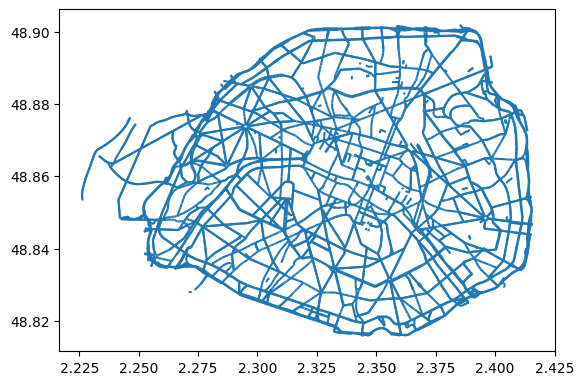

In [46]:
paris_road = match_network(G_parsed)

### Info on Deep Learning Frameworks (baseline models)

1. DeepTTE: https://github.com/UrbComp/DeepTTE/tree/master
Paper link: https://ojs.aaai.org/index.php/AAAI/article/view/11877

2. DeepGTT: https://github.com/boathit/deepgtt
Paper link: https://xiucheng.org/assets/pdfs/www19-deepgtt.pdf

3. MVSTM: https://github.com/775269512/SIGSPATIAL-2021GISCUP-4th-Solution (cannot open why)
Paper link: https://arxiv.org/abs/2109.07402

4. T-GCN: https://github.com/lehaifeng/T-GCN
Paper link: https://arxiv.org/abs/1811.05320

### Bike Data Processing

In [14]:
bike_path = 'data/mobike_shanghai_sample_updated.csv'
bike_data = pd.read_csv(bike_path)

In [16]:
bike_data

orderid  bikeid  userid       start_time  start_location_x  \
0         78387  158357   10080   2016/8/20 6:57           121.348   
1        891333   92776    6605  2016/8/29 19:09           121.508   
2       1106623  152045    8876  2016/8/13 16:17           121.383   
3       1389484  196259   10648  2016/8/23 21:34           121.484   
4        188537   78208   11735   2016/8/16 7:32           121.407   
...         ...     ...     ...              ...               ...   
102356  1479550  214335    1423  2016/8/28 18:03           121.478   
102357  1478273  160487    3067  2016/8/14 20:22           121.320   
102358   367733  179530   12746   2016/8/27 9:54           121.391   
102359    64915  167419     837   2016/8/20 6:04           121.515   
102360   326987   63172    2547   2016/8/9 10:51           121.521   

        start_location_y         end_time  end_location_x  end_location_y  \
0                 31.389   2016/8/20 7:04         121.357          31.388   
1                 31.279  2016/8/29 19:31         121.489          31.271   
2                 31.254  2016/8/13 16:36         121.405          31.248   
3                 31.320  2016/8/23 21:43         121.471          31.325   
4                 31.292   2016/8/16 7:41         121.418          31.288   
...                  ...              ...             ...             ...   
102356            31.297  2016/8/28 18:09         121.481          31.304   
102357            31.238  2016/8/14 20:28         121.312          31.235   
102358            31.307  2016/8/27 10:06         121.398          31.306   
102359            31.269   2016/8/20 6:10         121.510          31.272   
102360            31.261   2016/8/9 11:01         121.518          31.274   

                                                    track  
0       121.347,31.392#121.348,31.389#121.349,31.390#1...  
1       121.489,31.270#121.489,31.271#121.490,31.270#1...  
2       121.381,31.251#121.382,31.251#121.382,31.252#1...  
3       121.471,31.325#121.472,31.325#121.473,31.324#1...  
4       121.407,31.291#121.407,31.292#121.408,31.291#1...  
...                                                   ...  
102356  121.478,31.297#121.479,31.297#121.480,31.297#1...  
102357  121.312,31.235#121.313,31.235#121.313,31.236#1...  
102358  121.390,31.307#121.391,31.307#121.392,31.307#1...  
102359  121.510,31.272#121.510,31.273#121.511,31.273#1...  
102360  121.518,31.274#121.519,31.270#121.519,31.271#1...  

[102361 rows x 10 columns]

### Road Data Processing

In [18]:
nodes = pd.read_csv("data/Road network data/Shanghai_simplify_node.csv")
edges = pd.read_csv("data/Road network data/Shanghai_simplify_edge.csv")

In [19]:
nodes

Node ID           X          Y
0            0  121.531789  31.300807
1            1  121.457954  31.267865
2            2  121.421834  31.284741
3            3  121.549066  31.245043
4            4  121.529029  31.223608
...        ...         ...        ...
11479    11479  121.609651  31.203399
11480    11480  121.453835  31.199538
11481    11481  121.522932  31.283624
11482    11482  121.535583  31.266049
11483    11483  121.525304  31.252593

[11484 rows x 3 columns]

In [6]:
edges

Link ID  From Node  To Node    LENGTH     ID  POSSPEED  ROADWIDTH  FC  \
0            0          1     4912  0.298800  11834        70          8   4   
1            1          1     4323  1.766790  12298        70         12   1   
2            2          2     4178  0.101560  11317        30          4   7   
3            3          2    10590  0.027467   9272        60         12   4   
4            4          3     5073  0.258642  80605        40          8   7   
...        ...        ...      ...       ...    ...       ...        ...  ..   
18168    18168      11481     4709  0.286175   6582        60          7   4   
18169    18169      11482     9014  0.318574   5842        60         11   4   
18170    18170      11482     4959  0.176553   8005        30          4   7   
18171    18171      11483    10343  0.186907  43008        40          8   7   
18172    18172      11483     9935  0.383743   7398        60         12   6   

       DIR              PYNAME  
0        0                 NaN  
1        0  NAN BEI GAO JIA LU  
2        0                 NaN  
3        0           HU TAI LU  
4        0                 NaN  
...    ...                 ...  
18168    0       HUANG XING LU  
18169    0         NING GUO LU  
18170    0          HE JIAN LU  
18171    0         XU CHANG LU  
18172    0      YANG SHU PU LU  

[18173 rows x 10 columns]

C:\Users\Shaoxuan Zhang\AppData\Local\Temp\ipykernel_2992\125101032.py:3: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


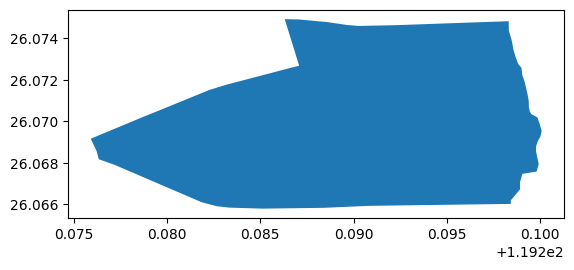

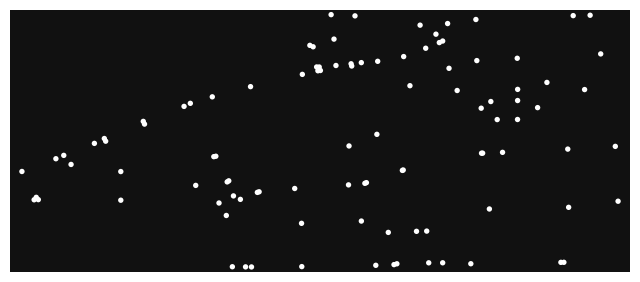

In [11]:
import osmnx as ox

ox.config(use_cache=True, log_console=True)

# define the place query
query = {'city': 'Shanghai'}

# get the boundaries of the place
gdf = ox.geocode_to_gdf(query)
gdf.plot()

# or just get the street network within the place
G = ox.graph_from_place(query, network_type='drive')
fig, ax = ox.plot_graph(G, edge_linewidth=0)

C:\Users\Shaoxuan Zhang\AppData\Local\Temp\ipykernel_12388\240177337.py:3: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True)


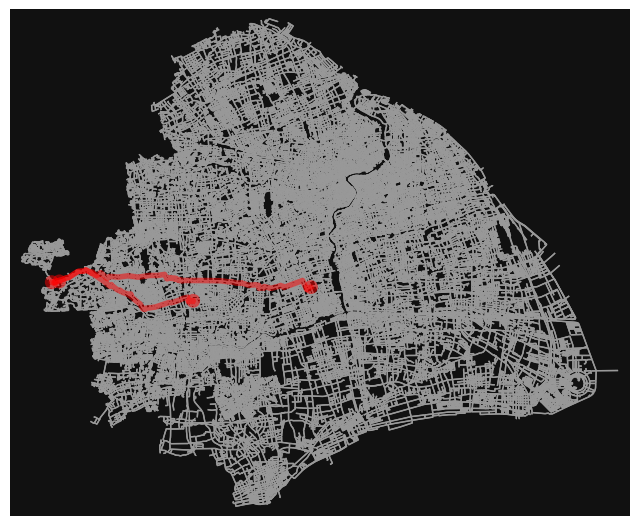

In [1]:
import networkx as nx
import osmnx as ox
ox.config(log_console=True, use_cache=True)

G = ox.graph_from_place('Shanghai, China', network_type='bike')

# pick 4 random nodes as origins/destinations for the 2 routes
orig1 = list(G.nodes())[0]
dest1 = list(G.nodes())[-1]
orig2 = list(G.nodes())[50]
dest2 = list(G.nodes())[-50]

# calculate shortest paths for the 2 routes
route1 = nx.shortest_path(G, orig1, dest1, weight='length')
route2 = nx.shortest_path(G, orig2, dest2, weight='length')

# create route colors
rc1 = ['r'] * (len(route1) - 1)
rc2 = ['b'] * len(route2)
rc = rc1 + rc2
nc = ['r', 'r', 'b', 'b']

# plot the routes
fig, ax = ox.plot_graph_routes(G, [route1, route2], route_color=rc, node_size=0)

In [10]:
for node in G.nodes:
    print(G.nodes.data()[node]['x'], G.nodes.data()[node]['y'])

121.4174151 31.0603866
121.4173487 31.060543
121.411033 31.075454
121.4009924 31.0715371
121.0047308 30.8856365
121.020044 30.8834379
121.0548367 30.8686504
121.0902158 30.8766351
121.4497082 30.9602134
121.4405557 30.9578524
121.4409692 30.9086541
121.4351022 30.9263197
121.4493343 30.9304946
121.4527668 30.9125887
121.436974 30.90755
121.4457435 30.9719053
121.4371677 30.9688822
121.4252926 30.9970985
121.4454588 30.9426576
121.4392153 30.9029479
121.4394123 30.9411402
121.3506526 30.8008037
121.4012808 30.7970937
121.4078254 30.7954595
121.4206241 30.7928525
121.4333999 30.7836688
121.3523056 30.7497225
121.3516094 30.7960139
121.3370231 30.8632062
121.3244939 30.8857304
121.321432 30.8948916
121.3338827 30.7398227
121.3359902 30.740864
121.2885534 30.7359076
121.2885786 30.7360578
121.3164948 30.7355328
121.2736175 30.7343094
121.1886479 31.0366766
121.1901314 31.0356718
121.1894136 31.0368512
121.1920778 31.0359871
121.2004958 31.0287342
121.1932283 31.0321084
121.1918633 31.03673

C:\Users\Shaoxuan Zhang\AppData\Local\Temp\ipykernel_12388\2927383039.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  shanghai = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


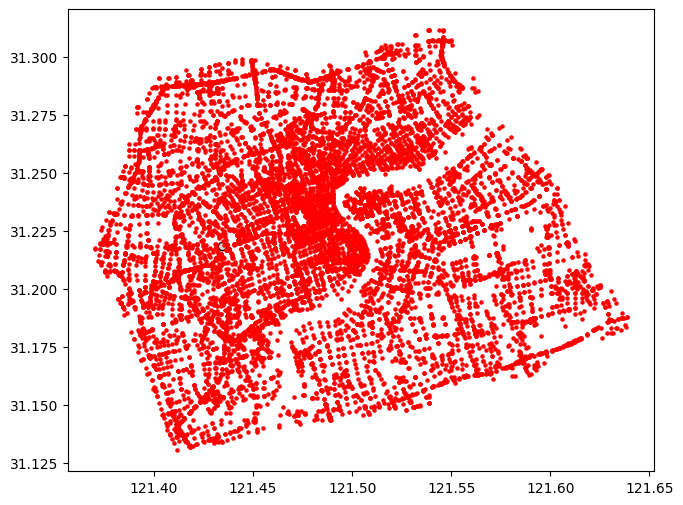

In [30]:
geometry = [Point(lon, lat) for lon, lat in zip(nodes['X'], nodes['Y'])]
gdf = gpd.GeoDataFrame(nodes, geometry=geometry, crs="EPSG:4326")

# Create a base map
shanghai = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
shanghai = shanghai[shanghai['name'] == 'Shanghai']

# Plot the points on the map
ax = shanghai.plot(figsize=(10, 6), color='lightgray', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

# Show the plot
plt.show()

### Data generator

In [ ]:
def edges_to_nodes(track):
    return [edge[0] for edge in track]

def nodes_to_edges(track):
    return [(track[i],track[i+1]) for i in range(len(track)-1)]

from datetime import datetime
def generate_time_v0(G,track,start_t,sampling_rate=1,v0=20):
    """
    Adds timestemps to a list of nodes every samping_rate seconds
    simulating a movement at constant speed v0 [km/h]
    """   
    extended_track=[]
    edge_list=nodes_to_edges(track)
    edge_index=0
    t=start_t
    t_enter_edge=t
    edge=edge_list[0]
    while edge!=edge_list[-1]:
        edge_info=G[edge[0]][edge[1]][0]

        l_traversed=(t-t_enter_edge)*(v0/3.6)
        l=edge_info["length"]
        if l_traversed>l:
            edge_index+=1
            edge=edge_list[edge_index]
            
            l_traversed-=l
            t_enter_edge=t
            #TODO: Asumes that the l excess fits in the next edge, but maybe no.
            #But next iter it checks if l_t>l and changes edge, but should not add time...
        osmid=edge_info['osmid']
        x=[t,edge[0],edge[1],osmid]
        extended_track.append(x)

        t+=sampling_rate

    return extended_track

import networkx as nx
from numpy.random import choice
def route_generator_v0(G,n=10,max_iter_factor=10,
                       start_t=None, data_every_t=24*3600, sampling_rate=1,
                       debug=False):
    """
    Generates a lsit of routes by selecting random points in the graph "G".

    Returns a list of n trajectories T.
    Each trajectory T[i] is a list of list elements in the format:
    [[timestamp, edge_start_node, edge_end_node, edge_osmid], ...]

    If there is not a path between selected nodes (not connected graph) it retries new nodes.
    A budget of n*max_iter_factor retries is set to avoid infinite loop.
    """

    if not start_t:
        start_t=datetime.today().timestamp()

    T=[]
    max_counts=n*max_iter_factor
    counts=0
    t=start_t
    while len(T)<n:
        try:
            orig=choice(list(G.nodes()))
            dest=choice(list(G.nodes()))
            track=nx.shortest_path(G, orig, dest, weight='length')
            extended_track=generate_time_v0(G,track,t,sampling_rate=sampling_rate)
            T.append(extended_track)
            t+=data_every_t
        except nx.exception.NetworkXNoPath:
            if debug:
                print(f"Repeating {len(T)}th trajectory...")
            else:
                pass

        counts+=1
        if counts==max_counts:
            print(f"WARNING: Not all tracks could be generated in {max_counts} iteratons.")
            break

    if debug:
        print("Generation done.") 
    return T

In [1]:
#T=route_generator_v0(G,n=100,sampling_rate=2,debug=True)